In [1]:
import torch
import os
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import shutil
import matplotlib.pyplot as plt
from collections import Counter, defaultdict


Analysis of Electronic Circuit Component Data Structure
📁 Folder Structure:
Base Path: components_data_clean
 components_data_clean/
   data_clean.yaml
   test/
     images/
       00001__1024__0___1648.png
       00001__1024__1648___3296.png
       00001__1024__2472___1648.png
       00001__1024__2472___4120.png
       00001__1024__3296___0.png
       00001__1024__3296___824.png
       00001__1024__4120___824.png
       00001__1024__4944___0.png
       00001__1024__5144___1648.png
       00001__1024__824___2472.png
       00020__1024__0___2736.png
       00020__1024__1648___2472.png
       00020__1024__2472___1648.png
       00020__1024__4116___2472.png
       00020__1024__4116___2736.png
       00020__1024__4116___824.png
       00020__1024__824___2472.png
       00020__1024__824___2736.png
       00025__1024__0___1984.png
       00025__1024__0___824.png
       00055__1024__0___2736.png
       00147__1024__2472___0.png
       00147__1024__4120___824.png
       00147__1024__4944___247

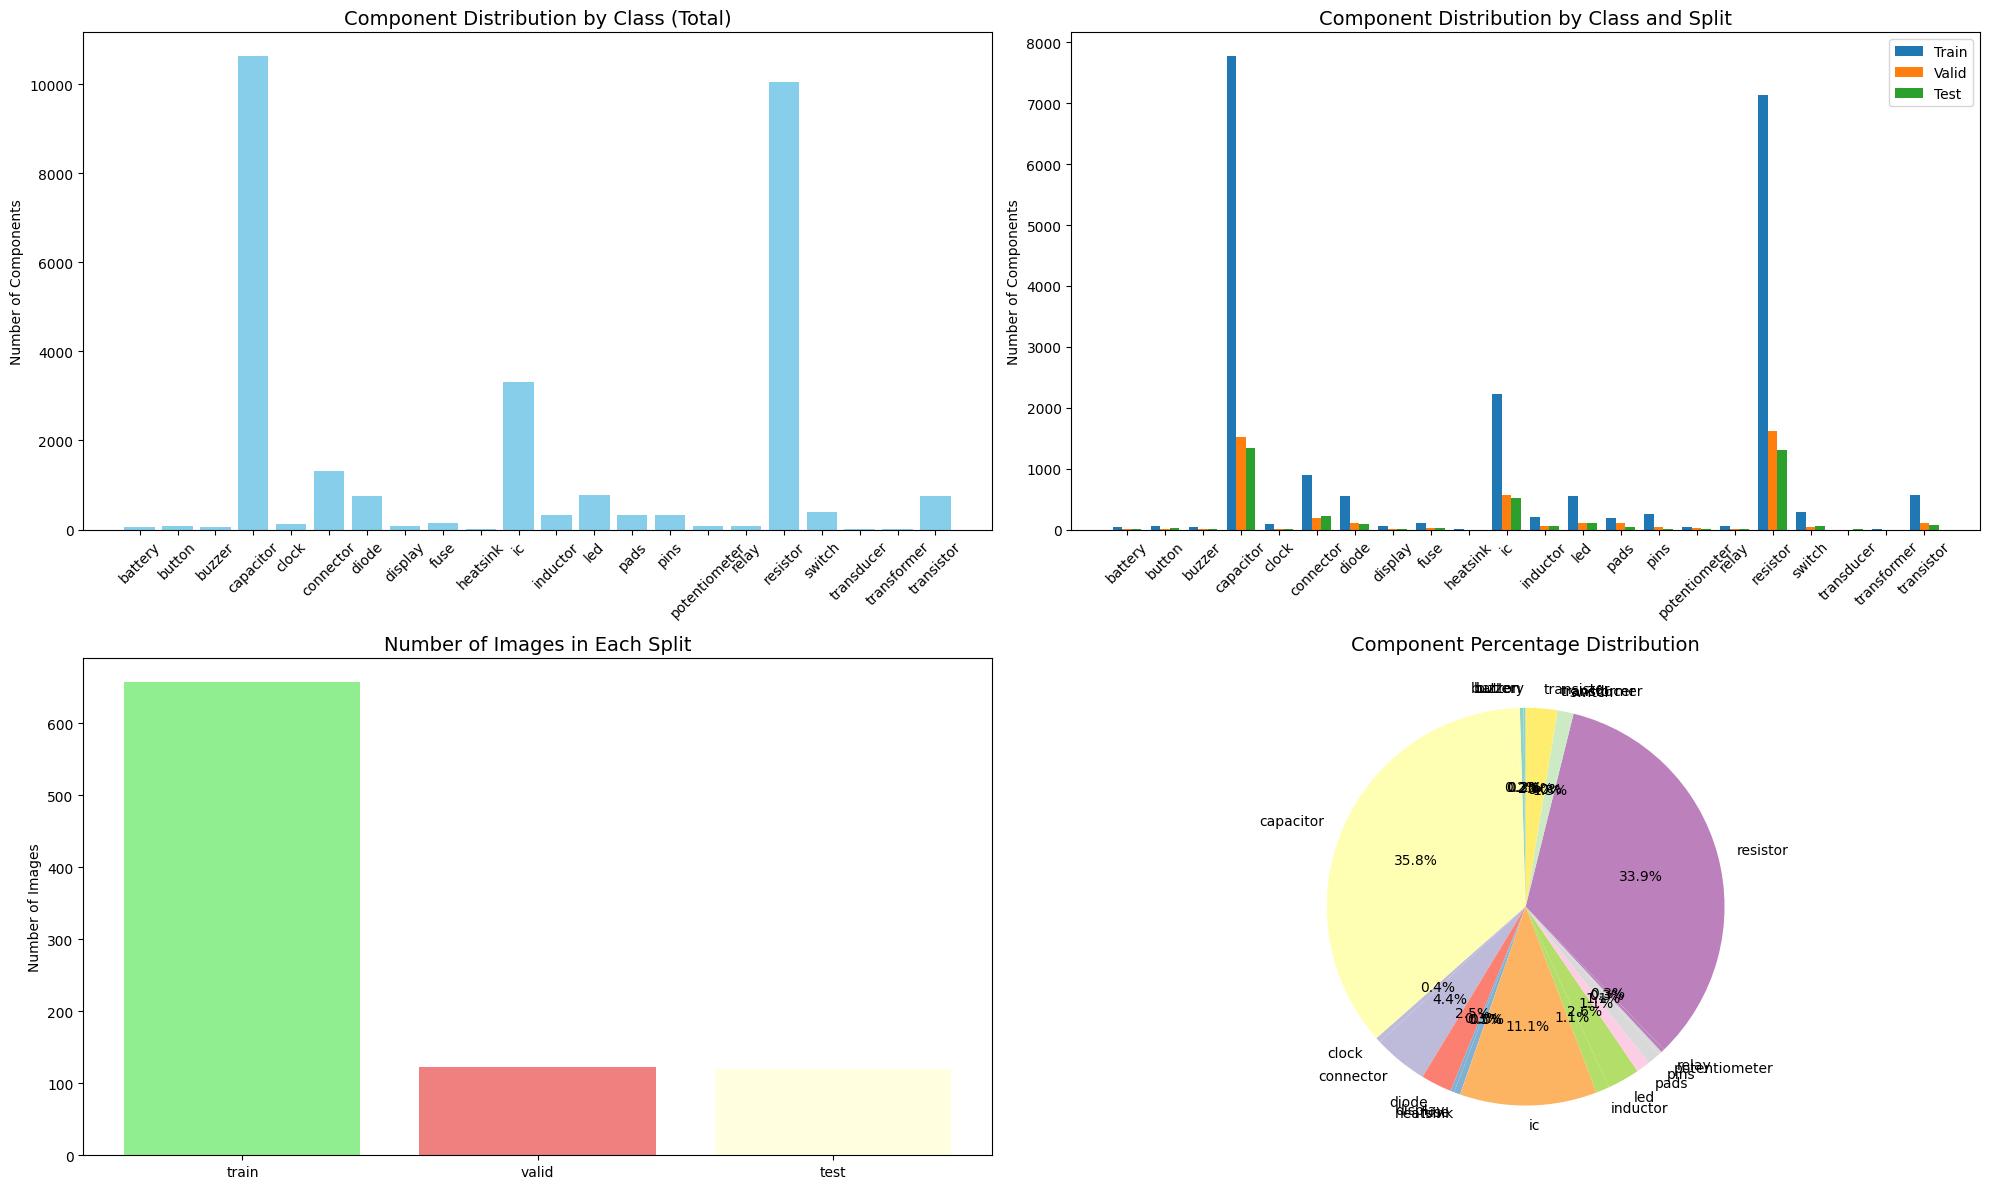


 Additional Statistics
• Train split: 32.17 components/image on average
• Valid split: 37.43 components/image on average
• Test split: 32.82 components/image on average

 Most Common Classes:
   capacitor: 10631 components
   resistor: 10049 components
   ic: 3302 components
   connector: 1311 components
   led: 776 components

 Least Common Classes:
   transformer: 2 components
   transducer: 4 components
   heatsink: 4 components
   battery: 54 components
   buzzer: 60 components


In [3]:
# Component Analysis and Counting in the Dataset


def analyze_components_structure():
    """Analyze the structure and count the components"""

    # Base path for the data
    data_path = "components_data_clean"

    print("=" * 60)
    print("Analysis of Electronic Circuit Component Data Structure")
    print("=" * 60)

    # Read the data.yaml file
    data_yaml_path = os.path.join(data_path, 'data_clean.yaml')
    with open(data_yaml_path, 'r', encoding='utf-8') as f:
        data_config = yaml.safe_load(f)

    print("📁 Folder Structure:")
    print(f"Base Path: {data_path}")

    # Analyze folders and files
    for root, dirs, files in os.walk(data_path):
        level = root.replace(data_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent} {os.path.basename(root)}/')
        sub_indent = ' ' * 2 * (level + 1)
        for file in files:
            print(f'{sub_indent} {file}')

    return data_config, data_path

def count_components_in_split(split_name, data_path):
    """Count components in a specific split (train/valid/test)"""

    labels_path = os.path.join(data_path, split_name, 'labels')
    images_path = os.path.join(data_path, split_name, 'images')

    print(f"\n🔍 Analyzing {split_name} Split:")
    print(f"   Labels Path: {labels_path}")
    print(f"   Images Path: {images_path}")

    if not os.path.exists(labels_path):
        print(f"    Labels folder not found!")
        return {}, 0, 0

    if not os.path.exists(images_path):
        print(f"    Images folder not found!")
        return {}, 0, 0

    # Count image files
    image_files = [f for f in os.listdir(images_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Count components from label files
    component_counter = Counter()
    total_components = 0
    label_files_count = 0

    for label_file in os.listdir(labels_path):
        if label_file.endswith('.txt'):
            label_files_count += 1
            label_file_path = os.path.join(labels_path, label_file)

            try:
                with open(label_file_path, 'r', encoding='utf-8') as f:
                    lines = f.readlines()

                for line in lines:
                    if line.strip():  # Ignore empty lines
                        parts = line.strip().split()
                        if len(parts) >= 5:  # YOLO format: class x_center y_center width height
                            class_id = int(parts[0])
                            component_counter[class_id] += 1
                            total_components += 1

            except Exception as e:
                print(f"   ❌ Error reading file {label_file}: {e}")

    print(f"    Statistics:")
    print(f"     • Number of Images: {len(image_files)}")
    print(f"     • Number of Label Files: {label_files_count}")
    print(f"     • Total Components: {total_components}")
    print(f"     • Number of Distinct Classes: {len(component_counter)}")

    return component_counter, len(image_files), total_components

def analyze_all_components():
    """Analyze all components in the dataset"""

    data_config, data_path = analyze_components_structure()

    print("\n" + "=" * 60)
    print(" Component Counting Across All Splits")
    print("=" * 60)

    splits = ['train', 'valid', 'test']
    all_components = Counter()
    split_stats = {}

    for split in splits:
        components, image_count, total_components = count_components_in_split(split, data_path)
        all_components.update(components)
        split_stats[split] = {
            'components': components,
            'images': image_count,
            'total_components': total_components
        }

    return data_config, split_stats, all_components

def visualize_component_distribution(data_config, split_stats, all_components):
    """Visualize the component distribution"""

    # Get class names
    class_names = data_config.get('names', [])

    print("\n" + "=" * 60)
    print(" Component Distribution by Class")
    print("=" * 60)

    # Display detailed statistics
    total_all_components = sum(all_components.values())

    print(f"\nTotal components across all splits: {total_all_components}")
    print("\nComponent breakdown by class:")
    print("-" * 80)
    print(f"{'Class':<20} {'Total':<10} {'Percent %':<10} {'Train':<10} {'Valid':<10} {'Test':<10}")
    print("-" * 80)

    for class_id in sorted(all_components.keys()):
        class_name = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
        total_count = all_components[class_id]
        percentage = (total_count / total_all_components) * 100

        train_count = split_stats['train']['components'].get(class_id, 0)
        valid_count = split_stats['valid']['components'].get(class_id, 0)
        test_count = split_stats['test']['components'].get(class_id, 0)

        print(f"{class_name:<20} {total_count:<10} {percentage:<10.2f} {train_count:<10} {valid_count:<10} {test_count:<10}")

    # Create charts
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # Chart 1: Component Distribution (Total)
    classes = [class_names[i] if i < len(class_names) else f"Class_{i}"
               for i in sorted(all_components.keys())]
    counts = [all_components[i] for i in sorted(all_components.keys())]

    ax1.bar(classes, counts, color='skyblue')
    ax1.set_title('Component Distribution by Class (Total)', fontsize=14)
    ax1.set_ylabel('Number of Components')
    ax1.tick_params(axis='x', rotation=45)

    # Chart 2: Component Distribution by Split
    splits = ['train', 'valid', 'test']
    split_data = {split: [split_stats[split]['components'].get(class_id, 0)
                          for class_id in sorted(all_components.keys())]
                  for split in splits}

    x = np.arange(len(classes))
    width = 0.25

    for i, split in enumerate(splits):
        ax2.bar(x + i * width, split_data[split], width, label=split.capitalize())

    ax2.set_title('Component Distribution by Class and Split', fontsize=14)
    ax2.set_ylabel('Number of Components')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(classes, rotation=45)
    ax2.legend()

    # Chart 3: Image Distribution
    split_images = [split_stats[split]['images'] for split in splits]
    ax3.bar(splits, split_images, color=['lightgreen', 'lightcoral', 'lightyellow'])
    ax3.set_title('Number of Images in Each Split', fontsize=14)
    ax3.set_ylabel('Number of Images')

    # Chart 4: Component Percentage
    percentages = [(count / total_all_components) * 100 for count in counts]
    colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))
    ax4.pie(percentages, labels=classes, autopct='%1.1f%%', startangle=90, colors=colors)
    ax4.set_title('Component Percentage Distribution', fontsize=14)

    plt.tight_layout()
    plt.show()

    # Additional Statistics
    print("\n" + "=" * 60)
    print(" Additional Statistics")
    print("=" * 60)

    # Average components per image
    for split in splits:
        images_count = split_stats[split]['images']
        components_count = split_stats[split]['total_components']
        if images_count > 0:
            avg_components = components_count / images_count
            print(f"• {split.capitalize()} split: {avg_components:.2f} components/image on average")

    # Most and least common classes
    most_common = all_components.most_common(5)
    least_common = all_components.most_common()[:-6:-1]

    print(f"\n Most Common Classes:")
    for class_id, count in most_common:
        class_name = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
        print(f"   {class_name}: {count} components")

    print(f"\n Least Common Classes:")
    for class_id, count in least_common:
        class_name = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
        print(f"   {class_name}: {count} components")

# Run the analysis
data_config, split_stats, all_components = analyze_all_components()
visualize_component_distribution(data_config, split_stats, all_components)

In [4]:
# Step 3: Define and Verify Class Statistics (with New Numbers)
class_counts = {
    'battery': 84, 'button': 462, 'buzzer': 159, 'capacitor': 11281,
    'clock': 228, 'connector': 2919, 'diode': 711, 'display': 59,
    'fuse': 131, 'ic': 2900, 'inductor': 418, 'led': 1700,
    'pads': 1031, 'pins': 113, 'potentiometer': 155, 'relay': 246,
    'resistor': 11775, 'switch': 467, 'transducer': 4, 'transformer': 45,
    'transistor': 803
}

# Calculate the total and the number of classes
N_total = sum(class_counts.values())
C = len(class_counts)
mean_instances = N_total / C

print("--- PCB Dataset Statistics Verification (Updated) ---")
print(f"Total Instances (Total N): {N_total}")
print(f"Total Number of Classes (C): {C}")
print(f"Mean Instances per Class (Mean): {mean_instances:.2f}")

# Display the most and least common classes for visual verification
print("\nMost Common Classes:")
sorted_counts = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
for name, count in sorted_counts[:3]:
    print(f"- {name}: {count} instances")

print("\nLeast Common Classes (Focus Area):")
for name, count in sorted_counts[-3:]:
    print(f"- {name}: {count} instances")

--- PCB Dataset Statistics Verification (Updated) ---
Total Instances (Total N): 35691
Total Number of Classes (C): 21
Mean Instances per Class (Mean): 1699.57

Most Common Classes:
- resistor: 11775 instances
- capacitor: 11281 instances
- connector: 2919 instances

Least Common Classes (Focus Area):
- display: 59 instances
- transformer: 45 instances
- transducer: 4 instances


In [5]:
# Step 4: Calculate and Store Class Weights

import torch # PyTorch is required for the final tensor conversion

# Pre-calculated variables (from Step 3):
N_total = 37507
C = 21
mean_instances = N_total / C # 1786.0476...

class_counts = {
    'battery': 84, 'button': 462, 'buzzer': 159, 'capacitor': 11281,
    'clock': 228, 'connector': 2919, 'diode': 711, 'display': 59,
    'fuse': 131, 'ic': 2900, 'inductor': 418, 'led': 1700,
    'pads': 1031, 'pins': 113, 'potentiometer': 155, 'relay': 246,
    'resistor': 11775, 'switch': 467, 'transducer': 4, 'transformer': 45,
    'transistor': 803
}

class_weights = []
# Recalculate mean_instances for precision (optional, but good practice)
mean_instances = N_total / C

# Loop through each class and calculate the weight
for count in class_counts.values():
    # Formula: Weight = Mean_Instances / Instances_in_This_Class
    weight = mean_instances / count
    class_weights.append(weight)

# Convert the list to a tensor for use in PyTorch (required for YOLO)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print(f"Calculated {len(class_weights)} class weights.")
print("\nFirst 5 weights: ", class_weights[:5])
print("\nExample Weights (Min/Max):")
print(f"  Max Weight (Transducer, Count=4): {max(class_weights):.4f}")
print(f"  Min Weight (Resistor, Count=11775): {min(class_weights):.4f}")

Calculated 21 class weights.

First 5 weights:  [21.2624716553288, 3.865903937332509, 11.233003893381252, 0.15832351910713757, 7.833542188805347]

Example Weights (Min/Max):
  Max Weight (Transducer, Count=4): 446.5119
  Min Weight (Resistor, Count=11775): 0.1517


In [6]:
# --- 1. Define Paths (Ensure Correctness) ---
# Using r'' for raw strings is good practice for Windows paths
DATASET_PATH = 'components_data_clean/data_clean.yaml'
MODEL_SAVE_DIR = 'model'
# The model will be saved in: model/pcb_detector_v8m/weights/best.pt (path depends on OS)

# --- 2. High-Precision Training Command Optimized for Imbalanced Data ---
print("--- Starting YOLOv8m training optimized for highest precision ---")
# FIX: Added '!' prefix to execute the yolo command in the shell
!yolo train \
model=yolov8m.pt \
data={DATASET_PATH} \
epochs=150 \
imgsz=1024 \
batch=8 \
device=0 \
patience=50 \
weight_decay=0.001 \
hsv_s=0.5 \
shear=2.0 \
degrees=15.0 \
scale=0.8 \
name=pcb_detector_v8m \
project={MODEL_SAVE_DIR}

print("\n--- Training started. The final model will be saved to Drive ---")

--- Starting YOLOv8m training optimized for highest precision ---
^C

--- Training started. The final model will be saved to Drive ---
